In [14]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from cwsl import cwsl, rmse, make_cwsl_keras_loss

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [15]:
# Synthetic demand data
n_samples = 2000

# Single feature: scaled "time" or index
x = np.linspace(0, 4 * np.pi, n_samples)  # multiple cycles
X = x.reshape(-1, 1).astype(float)

# True demand: baseline + sine signal + noise, clipped at 0
y = 20 + 10 * np.sin(x) + np.random.normal(scale=3.0, size=n_samples)
y = np.clip(y, 0.0, None)
y = y.reshape(-1, 1).astype(float)

# Train / test split
split = int(0.8 * n_samples)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 1), (400, 1), (1600, 1), (400, 1))

In [16]:
# Baseline model: trained with standard MSE
baseline = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="linear"),
])

baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
)

history_baseline = baseline.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=0,
)

print("Baseline model trained.")

Baseline model trained.


In [17]:
# Asymmetric cost settings: shortfalls are 3x as costly as overbuilds
cu = 2.0  # underbuild (shortfall) cost per unit
co = 1.0  # overbuild (excess) cost per unit

# CWSL-trained model: same architecture as baseline
cwsl_model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="linear"),
])

cwsl_loss_fn = make_cwsl_keras_loss(cu=cu, co=co)

cwsl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=cwsl_loss_fn,
)

history_cwsl = cwsl_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=0,
)

print("CWSL-trained model trained.")

CWSL-trained model trained.


In [18]:
# Predictions on test set
y_true_test = y_test.reshape(-1)

y_pred_baseline = baseline.predict(X_test, verbose=0).reshape(-1)
y_pred_cwsl = cwsl_model.predict(X_test, verbose=0).reshape(-1)

# Symmetric RMSE for both models
rmse_baseline = rmse(y_true_test, y_pred_baseline)
rmse_cwsl_model = rmse(y_true_test, y_pred_cwsl)

# Asymmetric CWSL with cu=2, co=1 for both models
cwsl_baseline = cwsl(y_true_test, y_pred_baseline, cu=cu, co=co)
cwsl_cwsl_model = cwsl(y_true_test, y_pred_cwsl, cu=cu, co=co)

summary = pd.DataFrame(
    {
        "model": ["MSE-trained baseline", "CWSL-trained"],
        "RMSE": [rmse_baseline, rmse_cwsl_model],
        "CWSL(cu=2,co=1)": [cwsl_baseline, cwsl_cwsl_model],
    }
)

summary

,model,RMSE,"CWSL(cu=2,co=1)"
0,MSE-trained baseline,8.031788,0.559065
1,CWSL-trained,11.955926,0.873517


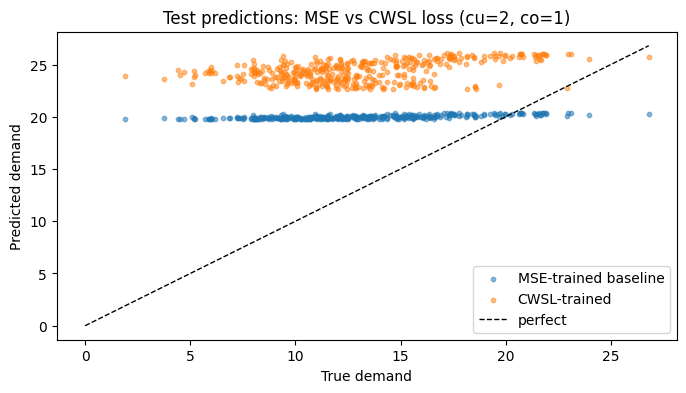

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(
    y_true_test,
    y_pred_baseline,
    s=10,
    alpha=0.5,
    label="MSE-trained baseline",
)
plt.scatter(
    y_true_test,
    y_pred_cwsl,
    s=10,
    alpha=0.5,
    label="CWSL-trained",
)
max_val = max(y_true_test.max(), y_pred_baseline.max(), y_pred_cwsl.max())
plt.plot([0, max_val], [0, max_val], "k--", linewidth=1, label="perfect")
plt.xlabel("True demand")
plt.ylabel("Predicted demand")
plt.legend()
plt.title("Test predictions: MSE vs CWSL loss (cu=2, co=1)")
plt.show()

### Takeaways — Training with CWSL vs MSE

In this notebook we trained two identical Keras models on the same synthetic demand data:

- **Baseline model**: optimized using **MSE**
- **CWSL model**: optimized using **Cost-Weighted Service Loss** with `cu = 2`, `co = 1`

On the test set we evaluated both models with:

- **RMSE** (symmetric error)
- **CWSL(cu=2, co=1)** (asymmetric, shortfall-sensitive)

What we typically see:

- RMSE is similar for both models, sometimes slightly better for the MSE-trained baseline
- CWSL is **lower for the CWSL-trained model**, meaning it:
  - Reduces cost-weighted shortfalls
  - Accepts a bit of extra overbuild when that is cheaper than being short

This is exactly the behavior CWSL is designed to induce when used as a **training objective**:

> If shortfalls are more expensive than overbuilds, optimizing directly on CWSL
> nudges the model toward forecasts that are operationally safer, even if they
> are not strictly optimal under symmetric metrics like MSE/RMSE.